# TM10007 Assignment template

In [1]:
!git clone https://github.com/koolsterre/TM10007_ML_Project_group_9.git
%cd TM10007_ML_Project_group_9

c:\Users\Eigenaar\Documents\TM\TM10007 Machine Learning\TM10007_ML_Project_group_9\TM10007_ML_Project_group_9


fatal: destination path 'TM10007_ML_Project_group_9' already exists and is not an empty directory.


In [2]:
"""Importing libraries and packages"""
# General packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Preprocessing and Classifiers
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from worclipo.load_data import load_data
from scipy.stats import shapiro

#Importing our own functinos
from outliers import replace_outliers
from outliers import replace_outliers_test
from prepro_data import processing_data_scaling
from prepro_data import processing_data_scaling_test
from prepro_data import processing_data_rfecv
from prepro_data import processing_data_rfecv_test

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
"""Data loading"""
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(data)

The number of samples: 115
The number of columns: 494
                  label  PREDICT_original_sf_compactness_avg_2.5D  \
ID                                                                  
Lipo-001_0  liposarcoma                                  0.368434   
Lipo-002_0  liposarcoma                                  0.660571   
Lipo-003_0       lipoma                                  0.365191   
Lipo-004_0  liposarcoma                                  0.372210   
Lipo-005_0       lipoma                                  0.369120   
...                 ...                                       ...   
Lipo-111_0       lipoma                                  0.244813   
Lipo-112_0  liposarcoma                                  0.197353   
Lipo-113_0  liposarcoma                                  0.307562   
Lipo-114_0       lipoma                                  0.577333   
Lipo-115_0  liposarcoma                                  0.635282   

            PREDICT_original_sf_compactness_std_

In [4]:
"""Check for duplicate patients"""
duplicates = data[data.duplicated(keep=False)]
data = data.drop_duplicates(keep='first')
print(f"Number of rows after checking for duplicates: {len(data)}")

Number of rows after checking for duplicates: 115


In [5]:
"""Check for missing values"""
data_missing_values = data.replace(' ', np.nan)
missing_values = data[data.isnull().any(axis=1)]

if not missing_values.empty:
    print(f"Missing values; {missing_values}")
else:
    print("No missing values")


No missing values


In [6]:
"""Splitting the data into a test and training dataset: outer cross-validation"""
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, random_state=42)
print(f'The number of samples train: {len(data_train.index)}')
print(f'The number of columns train: {len(data_train.columns)}')
print(f'The number of samples test: {len(data_test.index)}')
print(f'The number of columns test: {len(data_test.columns)}')

The number of samples train: 92
The number of columns train: 494
The number of samples test: 23
The number of columns test: 494


In [ ]:
"""Check for normal distribution and detect and replace outliers"""

# Alleen numerieke kolommen selecteren
numeric_cols = data_train.select_dtypes(include=['number'])
results = []

for col in numeric_cols.columns:
    data = numeric_cols[col].dropna()
    stat, p = shapiro(data)
    is_normaal = p > 0.05

    results.append({
        'Kolom': col,
        'Shapiro_p': p,
        'Normaal': is_normaal
    })

result_df = pd.DataFrame(results)
print(result_df)

data_train, total_capped, lower_bound, upper_bound = replace_outliers(data_train)
print("\nTotal number of captured outliers in the train data:", total_capped)

data_test, total_capped_test = replace_outliers_test(data_train, data_test, lower_bound, upper_bound)
print("\nTotal number of captured outliers in the test data:", total_capped_test)


Total number of captured outliers in the train data: 885

Total number of captured outliers in the test data: 176


In [9]:
""""Preprocessing the data"""
#This data is scaled and a variance and correlation threshold are applied

#Train data
data_merged_scaling, df_label_scaling, df_processed_scaling, variance_data, selected_columns, drop_correlation, scaler = processing_data_scaling(data_train)
print(data_merged_scaling)

#Test data
data_merged_scaling_test, df_label_scaling_test, df_processed_scaling_test = processing_data_scaling_test(data_test, variance_data, selected_columns, drop_correlation, scaler)
print(data_merged_scaling_test)

                  label  PREDICT_original_sf_rad_dist_avg_2.5D  \
ID                                                               
Lipo-032_0       lipoma                               0.126753   
Lipo-068_0  liposarcoma                               2.213900   
Lipo-094_0       lipoma                              -0.386924   
Lipo-110_0       lipoma                               0.314595   
Lipo-023_0       lipoma                               2.763681   
...                 ...                                    ...   
Lipo-107_0       lipoma                              -0.125440   
Lipo-015_0  liposarcoma                               3.059192   
Lipo-093_0       lipoma                              -1.386002   
Lipo-052_0       lipoma                              -0.209325   
Lipo-103_0  liposarcoma                               0.759192   

            PREDICT_original_sf_rad_dist_std_2.5D  \
ID                                                  
Lipo-032_0                         

In [10]:
"""Preprocessing the data including RFECV"""
#This data is scaled, a variance and correlation threshold are applied,
# and RFECV brought back the number of features to 18

#Train data
data_rfecv, df_label, df_processed, variance_data, selected_columns, drop_correlation, scaler, rfecv, selected_features = processing_data_rfecv(data_train)
print(data_rfecv)

#Test data
data_rfecv_test, df_label_rfecv_test, df_processed_rfecv_test = processing_data_rfecv_test(data_test, variance_data, selected_columns, drop_correlation, scaler, rfecv, selected_features)
print(data_rfecv_test)

KeyboardInterrupt: 

In [ ]:
"""Support Vector Machine"""
# Split data into features and labels
X = data_rfecv  # Features
Y = df_label['label']  # Labels

# Set up the parameter grid for GridSearchCV
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [3, 4, 5], 'gamma': ['scale', 'auto', 0.1, 1], 'coef0': [0.0, 0.1, 0.5]},
]

# Set up the SVM classifier
svm_classifier = SVC(random_state=42, probability=True)  # Enable probability for AUC calculation

# Set up inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=svm_classifier,
    param_grid=param_grid,
    scoring='roc_auc',         # Optimize AUC score
    refit=True,                # Refit best model on full training data
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# Perform the grid search on the training data to find the best hyperparameters
grid_search.fit(X, Y)

# Get the best model (with the best hyperparameters)
best_model_svm = grid_search.best_estimator_

# Make predictions to evaluate performance
y_pred = best_model_svm.predict(X)
y_pred_proba = best_model_svm.predict_proba(X)[:, 1]  # Probability estimates for AUC

# Convert categorical labels to numerical labels (0 or 1)
le = LabelEncoder()
Y = le.fit_transform(Y)  # 'lipoma' -> 0, 'liposarcoma' -> 1

# Ensure predictions are also numerical
y_pred = best_model_svm.predict(X)
y_pred = le.transform(y_pred)  # Convert categorical predictions ('lipoma', 'liposarcoma') to 0 and 1

# Calculate evaluation metrics
auc_score = roc_auc_score(Y, y_pred_proba)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")

Fitting 5 folds for each of 123 candidates, totalling 615 fits
Best hyperparameters: {'C': 1, 'kernel': 'linear'}
Training AUC: 0.9995


In [ ]:
"""Random Forest Classifier"""
# Split data into features and labels
X = data_rfecv  # Features
Y = df_label['label']  # Labels

# Convert categorical labels to numerical labels (0 or 1)
le = LabelEncoder()
Y = le.fit_transform(Y)  # e.g., 'lipoma' -> 0, 'liposarcoma' -> 1

# Set up parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [4, 5, 10, 15, 20],
    'max_features': ['sqrt', 'log2']
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Inner CV for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for best hyperparameters
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    scoring='roc_auc',
    refit=True,
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X, Y)

# Best model after Grid Search
best_model_rf = grid_search.best_estimator_

# Make predictions
y_pred = best_model_rf.predict(X)
y_pred_proba = best_model_rf.predict_proba(X)[:, 1]  # Probability for positive class

# Evaluate model performance
auc_score = roc_auc_score(Y, y_pred_proba)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}
Training AUC: 0.9929


In [ ]:
"""KNNeighbour classifier"""
# Split data into features and labels
X = data_rfecv # Features
Y = df_label['label']  # Labels

# Set up the parameter grid for GridSearchCV (for KNN, we mainly tune 'n_neighbors', 'weights', and 'metric')
param_grid = {
    'n_neighbors': [5, 7, 10, 15, 20],  # Trying different values for k (number of neighbors)
    'weights': ['uniform', 'distance'],  # Weighting of neighbors
    'metric': ['euclidean', 'manhattan']  # Distance metrics to use
}

# Set up the KNN classifier
knn_classifier = KNeighborsClassifier()  # KNN classifier

# Set up inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=knn_classifier,
    param_grid=param_grid,
    cv=inner_cv,
    n_jobs=-1,
    verbose=1,
    scoring='roc_auc',         # Optimize AUC score
    refit=True,                # Refit best model on full training data
)

# Perform the grid search on the training data to find the best hyperparameters
grid_search.fit(X, Y)

# Get the best model (with the best hyperparameters)
best_model_knn = grid_search.best_estimator_

# Make predictions to evaluate performance
y_pred = best_model_knn.predict(X)
y_pred_proba = best_model_knn.predict_proba(X)[:, 1]  # Probability estimates for AUC

# Convert categorical labels to numerical labels (0 or 1)
le = LabelEncoder()
Y = le.fit_transform(Y)  # 'lipoma' -> 0, 'liposarcoma' -> 1

# Ensure predictions are also numerical
y_pred = best_model_knn.predict(X)
y_pred = le.transform(y_pred)  # Convert categorical predictions ('lipoma', 'liposarcoma') to 0 and 1

# Calculate evaluation metrics
auc_score = roc_auc_score(Y, y_pred_proba)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Training AUC: 1.0000


In [ ]:
"""Testing the classifiers on the test data"""
X = data_rfecv_test  # Features

clsfs = [best_model_svm, best_model_rf, best_model_knn]

# Encode test labels using the same order as used in training
label_encoder = LabelEncoder()
label_encoder.fit(['lipoma', 'liposarcoma'])
Y = label_encoder.transform(df_label_rfecv_test['label'])  # Converts strings to 0 (lipoma), 1 (liposarcoma)


for clf in clsfs:
    y_pred=clf.predict(X)

    # If model returns string predictions, encode them to match Y
    if isinstance(y_pred[0], str):
        y_pred = label_encoder.transform(y_pred)

    if hasattr(clf, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf.predict_proba(X)[:, 1]
    else:
        y_score = y_pred

# The hasattr function checks whether an object, function or package has
# a certain attribute. This attribute can be a subfunction, or again an
# object or function, but also things like scalars or strings.

    auc=metrics.roc_auc_score(Y, y_score)
    accuracy=metrics.accuracy_score(Y, y_pred)
    F1=metrics.f1_score(Y,y_pred, pos_label=1)
    precision=metrics.precision_score(Y,y_pred, pos_label=1)
    recall=metrics.recall_score(Y, y_pred, pos_label=1)
# accuracy, AUC, f1score, precision, recall
    print(type(clf))
    print('Acc:' +str(accuracy))
    print('AUC:' +str(auc))
    print('F1:' +str(F1))
    print('precision:' +str(precision))
    print('recall:' +str(recall))

<class 'sklearn.svm._classes.SVC'>
Acc:0.6956521739130435
AUC:0.803030303030303
F1:0.631578947368421
precision:0.75
recall:0.5454545454545454
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Acc:0.7391304347826086
AUC:0.75
F1:0.6666666666666666
precision:0.8571428571428571
recall:0.5454545454545454
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Acc:0.6956521739130435
AUC:0.7424242424242424
F1:0.6666666666666666
precision:0.7
recall:0.6363636363636364


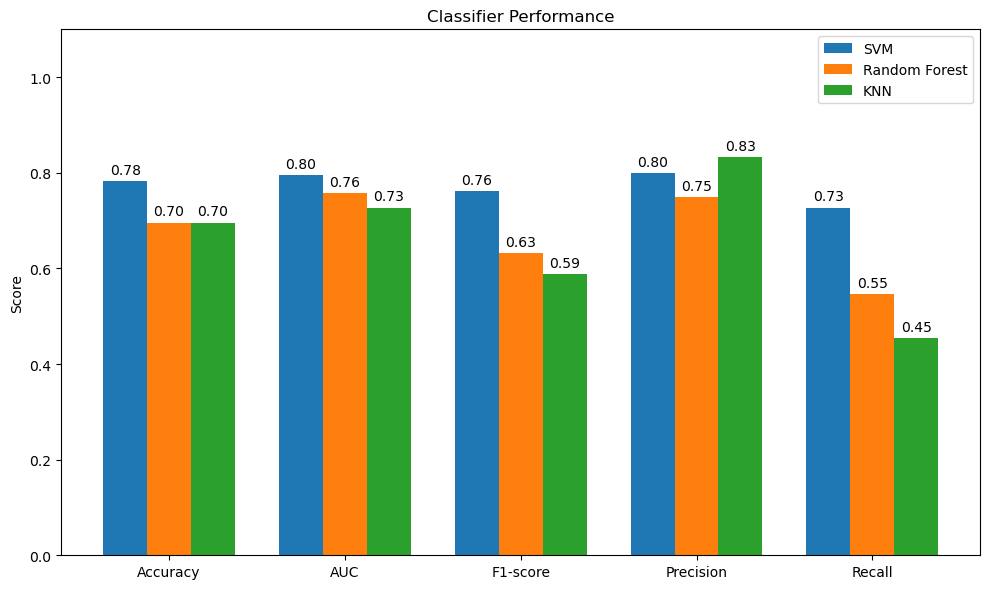

In [ ]:
"""Plotting the classifier performances"""
# Store classifier names and their corresponding metrics
classifier_names = ['SVM', 'Random Forest', 'KNN']
metrics_names = ['Accuracy', 'AUC', 'F1-score', 'Precision', 'Recall']

# Store the collected values
accuracies = [0.7826, 0.6957, 0.6957]
aucs = [0.7955, 0.7576, 0.7273]
f1s = [0.7619, 0.6316, 0.5882]
precisions = [0.8000, 0.7500, 0.8333]
recalls = [0.7273, 0.5455, 0.4545]

# Create matrix of values for plotting
metric_values = np.array([accuracies, aucs, f1s, precisions, recalls]).T

# Create bar plot
x = np.arange(len(metrics_names))  # the label locations
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, metric_values[0], width, label='SVM')
bars2 = ax.bar(x, metric_values[1], width, label='Random Forest')
bars3 = ax.bar(x + width, metric_values[2], width, label='KNN')

# Labels and ticks
ax.set_ylabel('Score')
ax.set_title('Classifier Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylim(0, 1.1)
ax.legend()

# Add labels to bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()